In [6]:
from glob import glob
import matplotlib.pyplot as plt
import orbax
from flax.training import orbax_utils ### need this for orbax.checkpoint to be found? 

### Some Preliminary Training Results

In [7]:

orbax_ckptr = orbax.checkpoint.PyTreeCheckpointer()
checkpoint_files = glob('../exps/blues_driver/1/*/ckpt')
print(checkpoint_files)

['../exps/blues_driver/1/Gaussian_blues_driver/ckpt', '../exps/blues_driver/1/Wendland_blues_driver/ckpt', '../exps/blues_driver/1/MaternOneHalf_blues_driver/ckpt']


In [10]:

cp_gauss,cp_wendland,cp_maternonehalf = (orbax_ckptr.restore(cp_file) for cp_file in checkpoint_files)

In [11]:
train_losses = [cp['losses'][:,0] for cp in [cp_gauss,cp_wendland,cp_maternonehalf]]

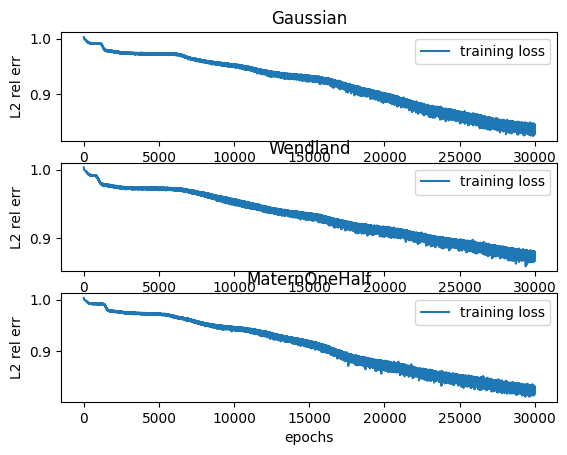

In [18]:
ks = ['Gaussian', 'Wendland', 'MaternOneHalf']

fig,ax = plt.subplots(len(train_losses))
for i,k in enumerate(ks):
    ax[i].plot(train_losses[i],label='training loss')
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel('L2 rel err')
    ax[i].legend()
    ax[i].set_title(k)

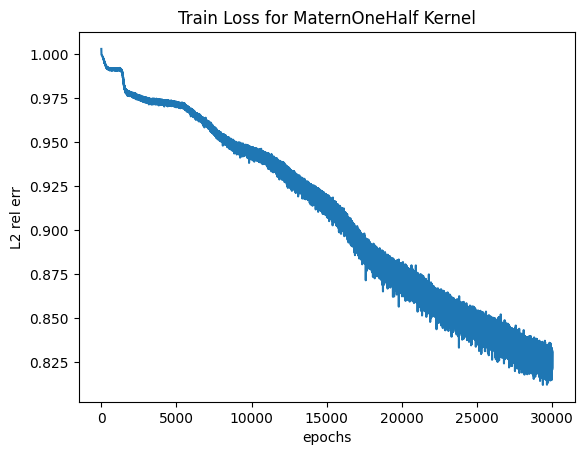

In [22]:
plt.plot(train_losses[-1])
plt.xlabel('epochs')
plt.ylabel('L2 rel err')
# plt.legend()
plt.title('Train Loss for MaternOneHalf Kernel')
plt.savefig('./audio_data_plots/matern_onehalf_trainloss_30k_epochs')

In [ ]:
## can i continue training, or should i just restart? 

### Making model predictions

### Post processing predictions back to audio!

In [ ]:

### output predictions from ML model are N functions  
def postprocess_audio(preds,
                      original_sps,
                      secs_per_fn=1,
                      shuffle=None, 
                      save=False, 
                      save_fp='output.mp3'):
    ## assume shuffle is w/o replacement 
    sampling_rate = preds.shape[1] / secs_per_fn #### each fn is 1 sec so the resolution is the sampl rate 
    if shuffle:
        deshuff = np.array([np.where(shuffle == i)[0] for i in range(len(shuffle))])
        preds = preds[deshuff]
    preds = preds.flatten()
    print(preds.shape)
    upsample = original_sps // sampling_rate
    print(upsample)
    upsampled_audio = signal.upfirdn([1],preds , up=upsample)
    print(upsampled_audio.shape)
    ## stack array now that it is in the right time order...
    if save:
        librosa.output.write_mp3(save_fp, upsampled_audio, original_sps)
    return upsampled_audio, original_sps


audio_array,sr = postprocess_audio(dataset,
                                   original_sps,
                                   secs_per_fn=1) ### sweeeett